In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from numpy.linalg import pinv, cond, norm, det, inv
from math import pi, e, pow, sqrt
from random import randint
from numpy import sin, cos

In [2]:
dataset = pd.read_csv('2d-em.csv',delim_whitespace=False,header=None,names=['x','y'])

In [3]:
dataset.head(10)

,x,y
0,-2.761410,-3.112991
1,4.007363,3.715906
2,2.492739,2.506346
3,1.218215,0.826689
4,-1.266938,-1.153239
5,2.928280,3.116988
6,-2.952492,-2.679652
7,-1.201038,0.002646
8,1.510646,1.299601
9,0.969209,-0.002195


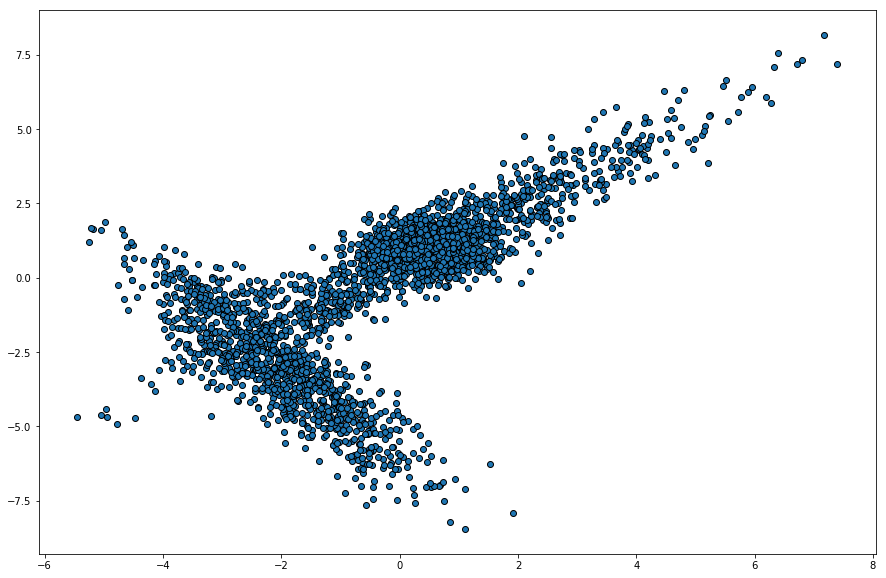

In [4]:
rawdata = dataset.as_matrix()
x, y = zip(*rawdata)
plt.figure(figsize=(15, 10))
plt.scatter(x, y, edgecolors="black")

In [5]:
class ExpectationMaximization:
    
    def __init__(self,X,clusters=2):
        self.X = X
        self.clusters = clusters
        self.row_count = X.shape[0]
        self.prior = []
        self.mu = []
        self.Sigma = []
        for i in range(clusters):
            self.prior.append(1/clusters)
            self.mu.append(self.X[randint(0,self.row_count)])
            self.Sigma.append(np.eye(2))
        self.probabilities = np.ones((self.row_count,clusters))
        self.weights = np.ones((self.row_count,clusters))
        self.labels = np.ones(self.row_count)
    
    def calc_mu(self,X):
        """calculates mu"""
        return np.mean(X,axis=0,dtype=np.float64)
    
    def center(self,vector,mu):
        """'corrects' data point by subtracting mu from vector"""
        return np.subtract(vector,mu)
    
    def calc_Sigma(self,cluster_index):
        """calculates Sigma"""
        summation = np.zeros((2,2))
        for row in range(self.row_count):
            centered = (self.center(self.X[row],self.mu[cluster_index])).reshape(2,1)
            wcct = np.multiply((np.dot(centered,centered.T)),self.weights[row,cluster_index])
            summation = np.add(summation,wcct)
        self.Sigma[cluster_index] = np.multiply(summation,(1/(np.sum(self.weights[:,cluster_index]))))
    
    def calc_prob(self,vector,mu,Sigma):
        """calculates the probability that vector is in the given class (defined by its mu and Sigma)"""
        determinant = sqrt(norm(2 * pi * Sigma))
        centered = self.center(vector,mu)
        power = (-0.5) * (np.dot(np.dot(centered.T,pinv(Sigma)),centered))
        result = (1/determinant) * pow(e,power)
        return result
    
    def mahalanobis_distance(self,vector,mu,Sigma):
        centered = self.center(vector,mu)
        return np.dot(np.dot(centered.T,pinv(Sigma)),centered)
    
    def e_step(self):
        for row in range(self.row_count):
            for cluster in range(self.clusters):
                self.probabilities[row,cluster] = self.calc_prob(self.X[row],self.mu[cluster],self.Sigma[cluster])
            weight_denominator = np.dot(self.probabilities[row],np.array(self.prior))
            for cluster in range(self.clusters):
                self.weights[row,cluster] = (self.probabilities[row,cluster]*self.prior[cluster])/weight_denominator

    def m_step(self):
        for cluster in range(self.clusters):
            cluster_weights = self.weights[:,cluster]
            self.prior[cluster] = np.mean(cluster_weights)
            self.mu[cluster] = (1/np.sum(cluster_weights)) * np.sum(np.multiply(self.X,cluster_weights[:,np.newaxis]),axis=0)
            #print(self.mu[cluster])
            self.calc_Sigma(cluster)
                                        
    def ex_max_2d(self,iterations=3):
        for iteration in range(iterations):
            self.e_step()
            self.m_step()
            #print(self.mu)
            #print(self.Sigma)
        for row in range(self.row_count):
            self.labels[row] = np.argmax(self.probabilities[row])
        return self.labels
    
    def oval(self,cov,numpoints=100,radius=1):
        arcs = np.linspace(0, 2 * pi, numpoints)
        x = radius * sin(arcs)
        y = radius * cos(arcs)
    
        xy = np.array(list(zip(x, y)))
        x, y = zip(*xy.dot(cov))
        return x,y

    def make_plot(self):
        plt.figure(figsize=(15, 10))

        colors = ['g', 'r', 'c', 'm', 'y', 'b' ]
        for i in range(len(self.Sigma)):
            # select elements based on expectation
            x, y = zip(*self.X[self.labels == i])

            plt.scatter(x, y, edgecolors="black",color=colors[i])

            # plot centers
            plt.scatter(self.mu[i][0],self.mu[i][1],s=500,color=colors[i])

            # plot ovals that show the shape of the  variances
            x, y = self.oval(self.Sigma[i],radius=2)
            x += self.mu[i][0]
            y += self.mu[i][1]
            plt.plot(x, y,linewidth=5,color=colors[i])

In [6]:
exmax_2 = ExpectationMaximization(rawdata)

In [7]:
exmax_2.mu

[array([ 0.37239631,  0.58387784]), array([-3.15037664, -3.19895068])]

In [8]:
exmax_2.ex_max_2d(iterations=10)

array([ 1.,  0.,  0., ...,  1.,  1.,  1.])

In [9]:
exmax_2.mu

[array([ 0.52421765,  1.03648124]), array([-2.048357  , -3.06078737])]

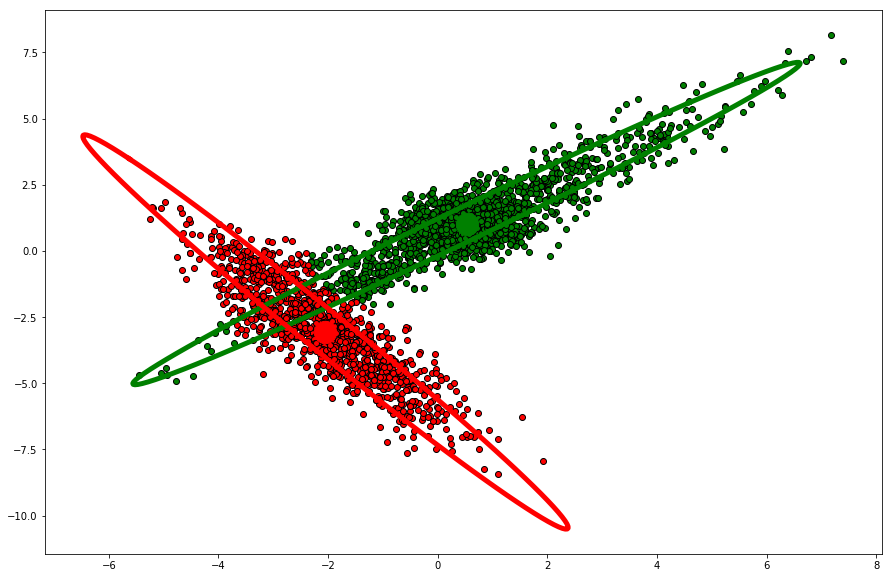

In [10]:
exmax_2.make_plot()

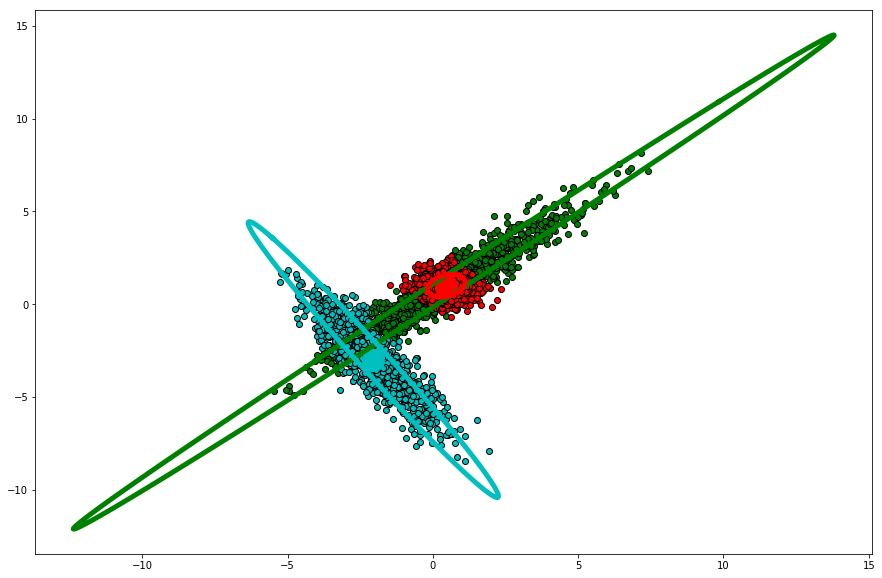

In [13]:
exmax_3 = ExpectationMaximization(rawdata,clusters=3)
exmax_3.ex_max_2d(iterations=10)
exmax_3.make_plot()

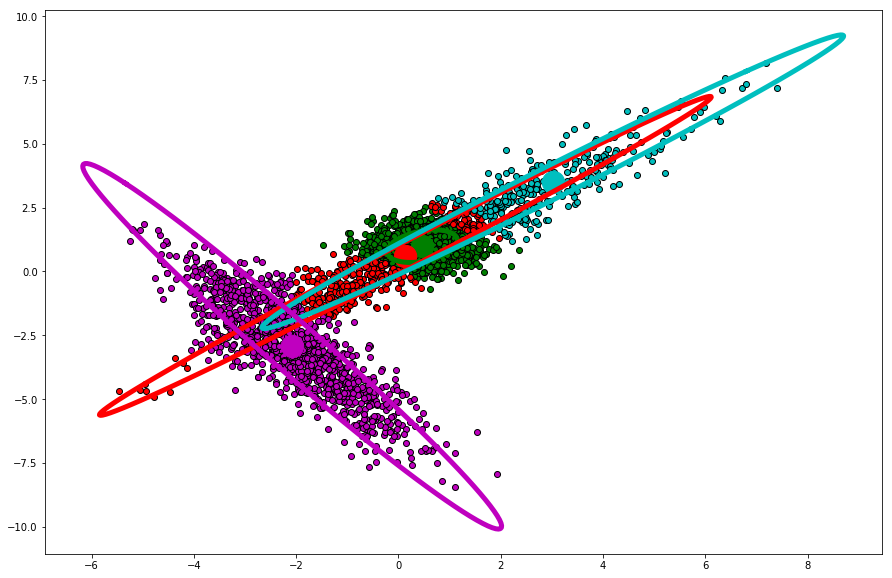

In [14]:
exmax_4 = ExpectationMaximization(rawdata,clusters=4)
exmax_4.ex_max_2d(iterations=10)
exmax_4.make_plot()

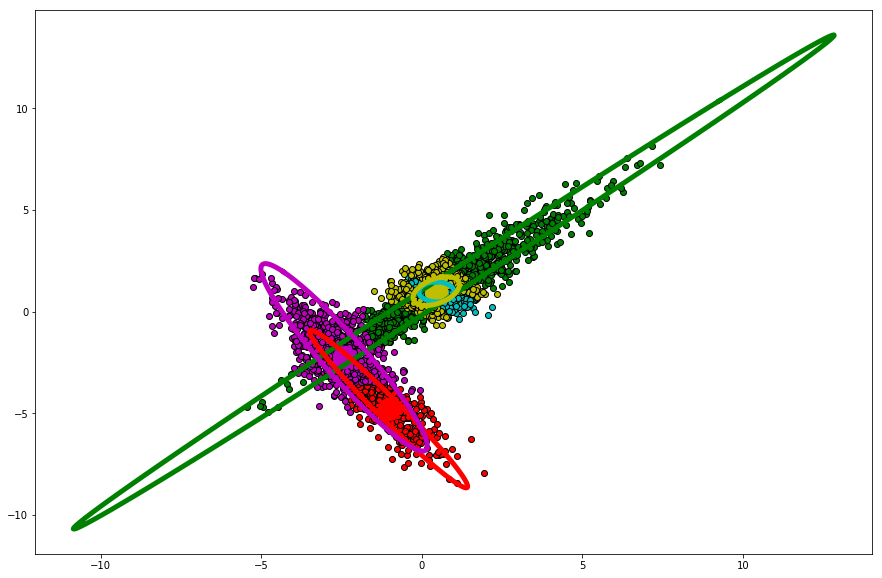

In [15]:
exmax_5 = ExpectationMaximization(rawdata,clusters=5)
exmax_5.ex_max_2d(iterations=10)
exmax_5.make_plot()